<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/ManyLocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kornia
# !pip install kornia_moons --no-deps
#!pip install kornia
#!pip install kornia_moons

In [2]:
import time
from contextlib import contextmanager
import torch
import numpy as np
import gc

def free_memory():
    # Liberação de memória
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

import numpy as np

def count_correct_matches(matches_matrix, threshold=0):
    n, _ = matches_matrix.shape
    count = 0
    for i in range(n):
        max_match = np.max(matches_matrix[i])
        # Verifica se o valor máximo é maior que o threshold e se o elemento na diagonal é igual ao máximo
        if max_match >= threshold and matches_matrix[i, i] == max_match:
            count += 1
    return count, n

def count_correct_matches(matches_matrix, threshold=0):
    n, _ = matches_matrix.shape
    count = 0
    for i in range(n):
        max_match = np.max(matches_matrix[i])
        if max_match >= threshold and matches_matrix[i, i] == max_match:
            if np.sum(matches_matrix[i] == max_match) == 1:
                count += 1
    return count, n


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Desativar para garantir a reprodutibilidade

@contextmanager
def medir_tempo(label: str = "Tempo de execução"):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print(f"{label}: {end - start} segundos")

def print_table(matrix):
    num_rows, num_cols = matrix.shape

    # Encontrando o número máximo de dígitos para alinhar corretamente
    max_width = len(str(num_rows * num_cols))

    # Imprimindo os índices das colunas
    print(f"    ".rjust(max_width + 3), end=" |")
    for col_idx in range(num_cols):
        print(f" Col{col_idx} ".center(10), end=" |")
    print()

    # Imprimindo uma linha de separação
    print(f"    ".rjust(max_width + 5)+"-" * (max_width + 1 + 11 * num_cols))

    # Imprimindo as linhas da tabela
    for row_idx in range(num_rows):
        print(f" Row{row_idx}".ljust(max_width + 1), end=" |")  # Adiciona um espaço extra na primeira célula
        for col_idx in range(num_cols):
            print(f" {matrix[row_idx, col_idx]} ".center(10), end=" |")
        print()

# Usando o context manager para medir o tempo de execução
with medir_tempo('Processamento concluído'):
    for _ in range(1000000):
        pass

Processamento concluído: 0.03569701099999634 segundos


In [3]:
import torch.nn as nn
import torchvision
import kornia as K
from abc import ABC, abstractmethod
import torch
from kornia import tensor_to_image


import matplotlib.pyplot as plt

def plot_tensor(tensor):
    """
    Plota um tensor PyTorch como uma imagem.

    Parâmetros:
    - tensor (torch.Tensor): Um tensor 2D para imagens em escala de cinza ou um tensor 3D para imagens RGB.
    """
    if tensor.dim() == 2:
        # Imagem em escala de cinza
        plt.imshow(tensor, cmap='gray')
    elif tensor.dim() == 3:
        # Convertendo o tensor de CxHxW para HxWxC para plotagem
        tensor = tensor.permute(1, 2, 0)
        plt.imshow(tensor)
    else:
        raise ValueError("O tensor deve ser 2D (imagem em escala de cinza) ou 3D (imagem RGB).")

    plt.axis('off')  # Remove os eixos para uma visualização mais limpa
    plt.show()

def plot_image_with_keypoints(image, keypoints):
    """
    Plota uma imagem e seus keypoints.

    Parâmetros:
    - image (torch.Tensor): A imagem original.
    - keypoints (torch.Tensor): Os keypoints detectados.
    """
    # Converter a imagem para o formato do matplotlib (H, W, C) e escala [0, 1] se necessário
    if image.dim() == 3:
        image = image.permute(1, 2, 0)
    if torch.max(image) > 1:
        image = image / 255.0

    plt.imshow(image.cpu().numpy())
    if keypoints.dim() == 3:
        keypoints = keypoints[0]  # Se os keypoints estiverem em um batch, pegue apenas o primeiro

    # Plotar os keypoints
    if keypoints.shape[1] == 2:
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
    elif keypoints.shape[1] == 3:  # Se os keypoints incluírem a confiança
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20 * keypoints[:, 2], marker='.', c='r')

    plt.axis('off')
    plt.show()

In [4]:
from abc import ABC, abstractmethod
from typing import Any, List, Tuple
from itertools import product
import numpy as np
import torch

class IPreprocessor(ABC):
    """
    Interface para um pré-processador de imagens.
    Define o contrato para classes que implementam operações de pré-processamento em imagens.
    """

    @abstractmethod
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        Aplica operações de pré-processamento à imagem fornecida.

        Parâmetros:
            image (torch.Tensor): A imagem de entrada como um tensor do PyTorch.

        Retorna:
            torch.Tensor: A imagem após o pré-processamento.
        """
        pass

class IGlobalFeatureStructurer(ABC):
    """
    Interface para a estruturação global de features através de grafo.
    """

    @abstractmethod
    def __call__(self, points: np.ndarray, featuresByPoints: np.ndarray) -> Tuple[np.ndarray,Any]:
        """
        Estrutura features globais de uma imagem em um grafo, utilizando pontos e suas características associadas.

        Args:
            points (np.ndarray): Array de pontos extraídos de uma imagem, onde cada ponto é uma coordenada 2D.
            featuresByPoints (np.ndarray): Array de características associadas a cada ponto.

        Returns:
            Tuple[np.ndarray, Any]: Um grafo representando a estruturação global das features e o objeto Delaunay utilizado para a triangulação.
        """
        pass

class IGlobalMatcher(ABC):
    """
    Interface para a similaridade global de features através de grafo.
    """
    @abstractmethod
    def __call__(self, matrixAdj0: np.ndarray, matrixAdj1: np.ndarray, threshold: float = 0.2) -> int:
        """
        Interface para invocar operações de comparação de grafos.

        Args:
            matrixAdj0: A primeira matriz de adjacência do grafo.
            matrixAdj1: A segunda matriz de adjacência do grafo.
            threshold: O limiar para avaliar correspondências.

        Returns:
            Um valor representando a similaridade entre os dois grafos.
        """
        pass


In [5]:
import torch
from kornia.feature import LocalFeature, DescriptorMatcher
from typing import Dict, Optional

class PreprocessPipeline(IPreprocessor):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((200, 200)),
            # Converte a imagem RGB para escala de cinza , necessario comentar para plotar
            K.color.RgbToGrayscale(),
        )

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = image#.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

class MyLocalFeatureMatcher:
    def __init__(self, local_feature: LocalFeature, descriptor_matcher: DescriptorMatcher):
        """
        Inicializa o matcher de características locais com um objeto LocalFeature para extração de características
        e um objeto DescriptorMatcher para o matching de descritores.

        Parâmetros:
            local_feature (LocalFeature): Um objeto LocalFeature para extração combinada de detector e descritor.
            descriptor_matcher (DescriptorMatcher): Um objeto DescriptorMatcher configurado para o matching de descritores.
        """
        self.local_feature = local_feature
        self.descriptor_matcher = descriptor_matcher

    def __call__(self, input) -> Dict[str, torch.Tensor]:
        """
        Extrai e match keypoints e descritores entre duas imagens.

        Args:
            image0: Primeira imagem.
            image1: Segunda imagem.

        Returns:
            Dicionário com keypoints, descritores e matches.
        """
        image0 = input["image0"]
        image1 = input["image1"]
        lafs0, responses0, descriptors0 = self.local_feature(image0)
        lafs1, responses1, descriptors1 = self.local_feature(image1)
        distance, matches = self.descriptor_matcher(descriptors0[0], descriptors1[0])
        return {
            "keypoints0": lafs0[0, :, :, 2].data,#[N, 2])
            "keypoints1": lafs1[0, :, :, 2].data,#[N, 2])
            "lafs0": lafs0,#[1, N, 2, 3]
            "lafs1": lafs1,#[1, N, 2, 3]
            "descriptors0": descriptors0[0],#[N, 128])
            "descriptors1": descriptors1[0],#[N, 128])
            "matches": matches,#[M, 2])
        }

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
class DelaunayGraph(IGlobalFeatureStructurer):
    @staticmethod
    def distancePoint(p1, p2):
        return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

    def buildConnection(self,tri):
        mapConnection = []
        for simplice in tri.simplices:
            mapConnection.extend([
                [simplice[0], simplice[1]],
                [simplice[1], simplice[2]],
                [simplice[2], simplice[0]]
            ])
        return mapConnection

    def buildMapGraph(self, mapConex,featuresByPoints):
        size = len(featuresByPoints)
        sample = np.matrix(np.ones((size, size)) * np.inf)
        for i in range(size):
            sample[i, i] = 0
        for conexao in mapConex:
            distance = self.distancePoint(featuresByPoints[conexao[0]], featuresByPoints[conexao[1]])
            sample[conexao[0], conexao[1]] = distance
        return sample

    @staticmethod
    def plot_delaunay(points, tri, img):
        plt.imshow(img)
        plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy(), color='orange')
        plt.plot(points[:, 0], points[:, 1], 'o')
        dist = 3
        for i, point in enumerate(points):
            plt.text(point[0] + dist, point[1] + dist, f' {i}', color='red', fontsize=12)
        plt.show()

    def __call__(self, points, featuresByPoints):
        # Assume-se que os pontos são extraídos de uma imagem e já processados
        tri = Delaunay(points)
        # self.plot_delaunay(points,tri)
        mapConnection = self.buildConnection(tri)
        graph = self.buildMapGraph(mapConnection,featuresByPoints)
        return graph,tri


from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
class FloydWarshall(IGlobalMatcher):
    @staticmethod
    def floydWarshall(graph):
        graph = csr_matrix(graph)
        dist_matrix, _ = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
        return dist_matrix

    @staticmethod
    def match_matrix(mat_a, mat_b, threshold):
        mat_dist = mat_b - mat_a
        for i in range(mat_dist.shape[0]):
            mat_dist[i, :i] = 0  # Zera a metade inferior da matriz para evitar duplicação
        mat_dist = mat_dist * mat_dist  # Eleva as diferenças ao quadrado
        points = 0
        for i in range(mat_dist.shape[0]):
            for j in range(i + 1, mat_dist.shape[0]):
                if mat_dist[i, j] < threshold:
                    points += 1
        return points

    def __call__(self,matrixAdj0,matrixAdj1, threshold=0.2):
        matAdjFull0 = self.floydWarshall(matrixAdj0)
        matAdjFull1 = self.floydWarshall(matrixAdj1)
        simGraph = self.match_matrix(matAdjFull0,matAdjFull1,threshold)
        return simGraph

In [6]:

import torch
import torchvision
from kornia.feature import LocalFeatureMatcher, GFTTAffNetHardNet, DescriptorMatcher,KeyNetHardNet,SIFTFeatureScaleSpace,SIFTFeature,HesAffNetHardNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_sift_scale_matcher = MyLocalFeatureMatcher(
    SIFTFeatureScaleSpace(10,device=device), DescriptorMatcher('smnn', 0.8),#GFTTAffNetHardNet, KeyNetHardNet, SIFTFeature, SIFTFeatureScaleSpace
)
pp= PreprocessPipeline()
delaunayG = DelaunayGraph()  # Inicializa o construtor de grafo de Delaunay
# Compara as matrizes de distância dos dois grafos
floyd = FloydWarshall()

In [7]:
import matplotlib.pyplot as plt
import kornia as K  # Importe kornia se não já estiver importado

class MyDrawMatcher:
    def __init__(self, draw_dict=None) -> None:
        if draw_dict is None:
            draw_dict = {
                "inlier_color": (0.2, 1, 0.2),
                "tentative_color": (1.0, 0.5, 1),
                "feature_color": (0.6, 0.5, 0,0),
                "vertical": True,
            }
        self.draw_dict = draw_dict

    def __call__(self, img1_preprocessed, img2_preprocessed, output) -> None:
        from kornia_moons.viz import draw_LAF_matches
        # Use kornia.tensor_to_image to ensure the images are in the correct format for drawing
        img1 = K.tensor_to_image(img1_preprocessed.squeeze())
        img2 = K.tensor_to_image(img2_preprocessed.squeeze())

        # Assumes draw_LAF_matches is accessible and compatible with provided arguments
        draw_LAF_matches(
            output['lafs0'].cpu(),
            output['lafs1'].cpu(),
            output['matches'].cpu(),
            img1,
            img2,
            None,  # Or the inliers if available
            self.draw_dict
        )
        # Remove as bordas numéricas no plot (se aplicável)
        plt.tick_params(labelbottom=False, labelleft=False)  # Desativa os labels nos eixos
        plt.show()  # Exibe o plot



In [8]:
set_seed(42)


class ImageComparisonPipeline:
    # __slots__ = ['preprocessor', 'local_feature', 'descriptor_matcher', 'global_structurer', 'global_matcher']

    def __init__(self, preprocessor=None, local_feature: LocalFeature = None, descriptor_matcher: DescriptorMatcher = None, global_structurer=None, global_matcher=None):
        self.preprocessor = preprocessor
        self.local_feature = local_feature
        self.descriptor_matcher_ablation = descriptor_matcher
        self.descriptor_matcher_fixed=  DescriptorMatcher('snn', self.descriptor_matcher_ablation.th)
        self.global_structurer = global_structurer
        self.global_matcher = global_matcher
        

    def process_global(self, out,images,is_plot=False):
        matricesAdj = []

        for index in (0, 1):
            pts = out[f'keypoints{index}'][out['matches'][:, index]].cpu().detach().numpy()
            desc = out[f'descriptors{index}'][out['matches'][:, index]].cpu().detach().numpy()
            matrixAdj, _ = self.global_structurer(pts, desc)
            matricesAdj.append(matrixAdj)
            if is_plot:
                img = tensor_to_image(images[index].squeeze())
                DelaunayGraph.plot_delaunay(pts,_,img=img)
        return matricesAdj

    def run(self, inspection_images: torch.Tensor, reference_images: torch.Tensor,threshold=0.1, log=None,device=torch.device('cpu')) -> Dict[Tuple[int, int], float]:
        if not all([self.preprocessor, self.local_feature, self.descriptor_matcher_ablation, self.global_structurer, self.global_matcher]):
            raise ValueError("Pipeline components are not fully set.")
        n,m = inspection_images.shape[0],reference_images.shape[0]
        scores = np.zeros((n, m))
        count_match = np.zeros((n, m))
        myDraw =MyDrawMatcher()
        cache_reference = {}
       
        for i_index, i_image in enumerate(inspection_images):
            lafs0, responses0, descriptors0 = self.local_feature(i_image[:1][None])
            for r_index, r_image in enumerate(reference_images):
                if r_index not in cache_reference:
                    lafs1, responses1, descriptors1 = self.local_feature(r_image[:1][None])
                    cache_reference[r_index] = (lafs1, responses1, descriptors1)
                else:
                    lafs1, responses1, descriptors1 = cache_reference[r_index]
            
                distance_ablation, matches_ablation = self.descriptor_matcher_ablation(descriptors0[0], descriptors1[0])# ablation
                distance, matches = self.descriptor_matcher_fixed(descriptors0[0], descriptors1[0])
                out = {
                "keypoints0": lafs0[0, :, :, 2].data,#[N, 2])
                "keypoints1": lafs1[0, :, :, 2].data,#[N, 2])
                "lafs0": lafs0,#[1, N, 2, 3]
                "lafs1": lafs1,#[1, N, 2, 3]
                "descriptors0": descriptors0[0],#[N, 128])
                "descriptors1": descriptors1[0],#[N, 128])
                "matches": matches,#[M, 2])
                }

                
                #ignora quando existem poucos pontos, pois diminui a confianca(global)
                if(matches.shape[0]>=8):
                    try:
                        is_plot= False
                        if  i_index==3 and r_index in [3,12]:
                            print("({},{})=>*".format(i_index,r_index))
                            is_plot= True
                        matricesAdj = self.process_global(out,images=[i_image,r_image],is_plot=is_plot)
                        score = self.global_matcher(*matricesAdj, threshold=threshold)
                    except Exception as e:
                        score = 0   # possui poucos pontos     
                else:
                   score = 0    
                
                #ignora quando existem poucos pontos, pois diminui a confianca(local)
                num_match = matches_ablation.shape[0]  
                if num_match<8:
                    num_match= 0
                             
                # if log is not None and log in ('DEBUG') and i_index == r_index and i_index%20==0:
                if log is not None and log in ('DEBUG') and ( i_index==3 and r_index in [3,12]):
                    print(i_index,r_index ,out['keypoints0'].shape,out['descriptors0'].shape,out['matches'].shape,)
                    temp = out.copy()
                    temp['matches']=matches_ablation
                    myDraw(i_image.cpu(), r_image.cpu(),temp)

                count_match[i_index, r_index] = num_match # avaliacao pelo quantidade matching
                scores[i_index, r_index] = score # avaliacao pela correspondencia local+global

        if log is not None and log in ('INFO'):
            print_table(count_match)
            print("count_match : ",count_correct_matches(count_match,8))
            print_table(scores)
            print("scores : ",count_correct_matches(scores,8))

        return count_match,scores


import torch
from torchvision import datasets, transforms
import kornia.augmentation as KA
from torch.utils.data import DataLoader, Dataset




transform_original = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor()
])


import glob
from PIL import Image
class WoodsDataset(torch.utils.data.Dataset):
    """Fibers dataset. to train neural net"""

    def __init__(self, transform=None,train=True, root='./data/woods/',limit_train=0.5):
        np.random.seed(0)
        self.transform = transform
        self.data = np.array(sorted(glob.glob('{}*.jpg'.format(root))))

        limit_train = int(len(self.data)*limit_train)
        indices = np.random.permutation(len(self.data))
        # print("path ",path," len ",len(self.data)," limit_train ",limit_train)
        training_idx, test_idx = indices[:limit_train], indices[limit_train:]

        self.image_list = []
        if train:
            self.data = self.data[training_idx]
        else:
            self.data = self.data[test_idx]
        # print('train '+str(train),' ',len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filename = self.data[idx]
        img = Image.open(filename)
        img_t = self.transform(img)
        return img_t,'wood'
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device',device)
# someDataset = datasets.Flowers102(root='./data', split='train', download=True,transform=transform_original)
someDataset = WoodsDataset(root='./data/woods/', train=True,transform=transform_original)
flowers_loader = DataLoader(someDataset, batch_size=15, shuffle=True,)
total_elements = len(flowers_loader.dataset)
total_batches = len(flowers_loader)
print(f'Total de elementos no dataset: {total_elements} total batch: {total_batches}')



device cuda
Total de elementos no dataset: 354 total batch: 24


In [9]:
import torch
from kornia.feature import LocalFeature, LAFDescriptor, MultiResolutionDetector,SOSNet
from kornia.feature import CornerGFTT, PassLAF, LAFOrienter, LAFAffNetShapeEstimator
from kornia.feature.scale_space_detector import get_default_detector_config
# Assuming SOSNet can be correctly imported as shown before; adjust if needed.

    
class GFTTFeatureSosNet(LocalFeature): #0.9    |   0.005
    """Convenience module, which implements GFTT detector + SOSNet descriptor."""

    def __init__(
        self,
        num_features: int = 8000,
        upright: bool = False,
        device: torch.device = torch.device("cpu"),
        config: dict = None,  # Placeholder for your detector configuration
    ) -> None:
        if config is None:
            config = get_default_detector_config()  # Define your default detector config here if necessary
        
        detector = MultiResolutionDetector(
            CornerGFTT(),
            num_features,
            config,
            ori_module=PassLAF() if upright else LAFOrienter(19),
            aff_module=LAFAffNetShapeEstimator(preserve_orientation=True).eval(),
        ).to(device)

        # Initialize your descriptor (e.g., SOSNet) as before
        # Example with SOSNet - replace with actual initialization if different
        sosnet32 = SOSNet(pretrained=True)  # Placeholder; adjust according to actual SOSNet import
        sosnet32 = sosnet32.to(device).eval()

        descriptor = LAFDescriptor(sosnet32, patch_size=32, grayscale_descriptor=True).to(device)

        super().__init__(detector, descriptor)


In [10]:
images = torch.randn(1, 1, 256, 256)
teste = GFTTFeatureSosNet(num_features=20)
kp,_,desc = teste(images)
kp.shape,desc.shape

/tmp/ipykernel_620/1529415087.py:26: DeprecationWarning: `LAFAffNetShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=LAFAffNetShapeEstimator(preserve_orientation=True).eval(),


(torch.Size([1, 20, 2, 3]), torch.Size([1, 20, 128]))

(3,3)=>*


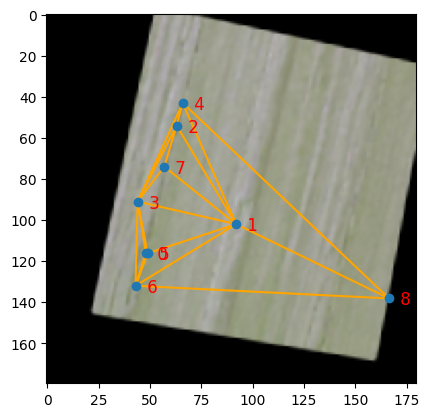

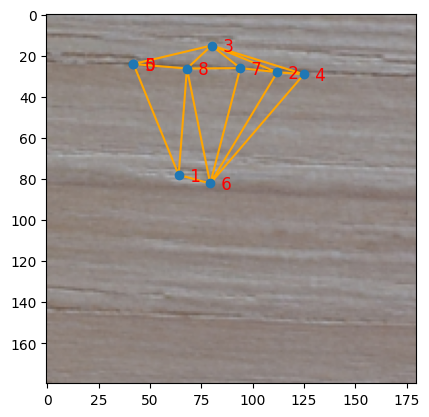

3 3 torch.Size([60, 2]) torch.Size([60, 128]) torch.Size([9, 2])


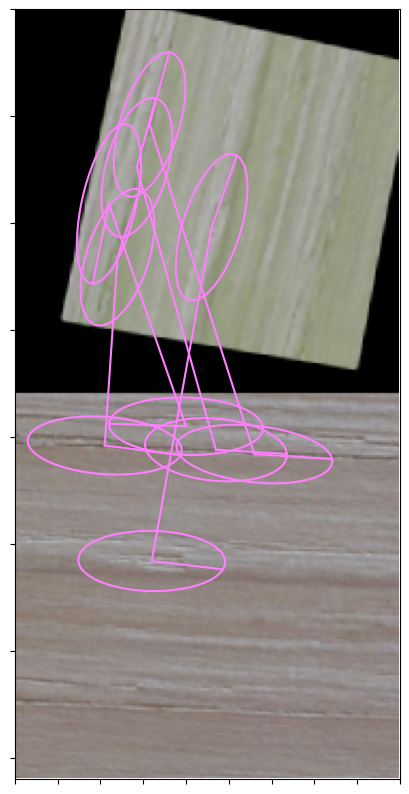

(3,12)=>*


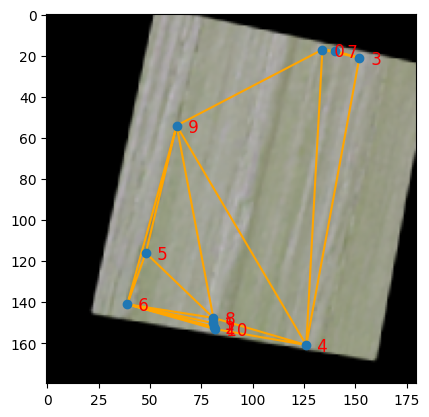

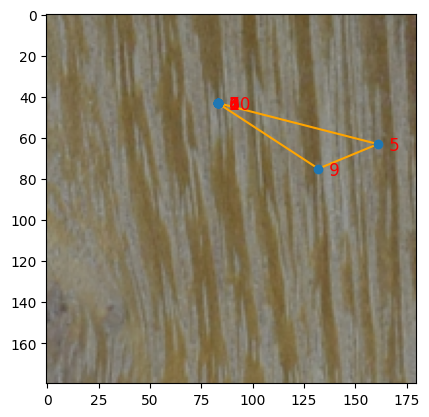

3 12 torch.Size([60, 2]) torch.Size([60, 128]) torch.Size([11, 2])


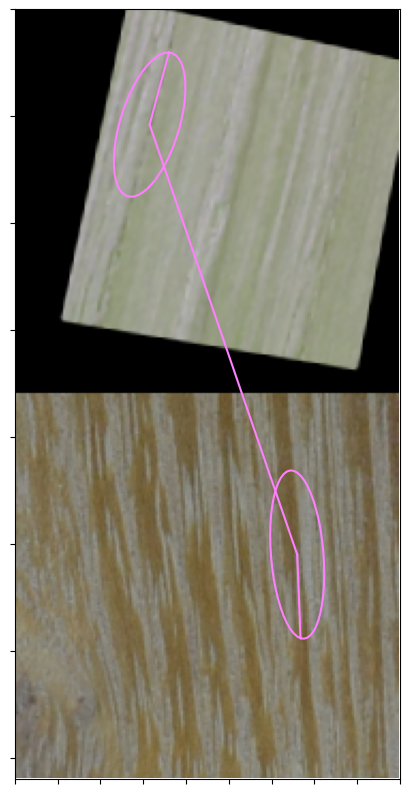

{'params': {'num_features': 60, 'feature_local_class': 'GFTTAffNetHardNet', 'distance': 0.95, 'threshold': 0.5}, 'matches': (4, 15), 'scores': (10, 15)}
Tempo de execução: 3.305810097999995 segundos
Parâmetros: {'num_features': 60, 'feature_local_class': 'GFTTAffNetHardNet', 'distance': 0.95, 'threshold': 0.5}
Matches: (4, 15)
Scores: (10, 15)


In [14]:
import torch
from itertools import product

def grid_search_pipeline(device, dataset_loader, param_grid):
    all_results = []
    transform_inspect = KA.AugmentationSequential(
        # KA.RandomHorizontalFlip(p=0.5),
        # KA.RandomVerticalFlip(p=0.5),
        KA. RandomMedianBlur((3, 3), p = 1),
        KA.RandomPerspective(0.3, p=0.75),
        KA.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2, p=0.75),#brightness=0.5, contrast=0.5, saturation=0.5, hue=0.15, p=0.75
        KA.RandomAffine(degrees=90, translate=(0.10, 0.10), scale=(0.90, 1.1), p=0.75),
        same_on_batch=True,
    )
    for num_features, feature_local_class, distance, threshold in product(*param_grid.values()):
        set_seed(42)
        # Configuração específica do extrator de features com a classe e número de features
        feature_extractor = feature_local_class(num_features, device=device)
        sum_matches,sum_scores,sum_total= 0,0,0
        # Configurar a pipeline com os parâmetros atuais
        pipeline = ImageComparisonPipeline(
            pp, 
            feature_extractor, 
            DescriptorMatcher('smnn', distance), 
            delaunayG, 
            floyd,
        )
        
        # Executar a pipeline e registrar resultados para o batch atual
        with medir_tempo():
            with torch.no_grad():
                for batch_idx, (original_batch, target) in enumerate(dataset_loader):
                    original_batch = original_batch.to(device)
                    inspection_images = transform_inspect(original_batch)
                    matches, scores = pipeline.run(inspection_images, original_batch,threshold=threshold, device=device, log='DEBUG')#log='DEBUG','INFO'
                    # print_table(matches)
                    # print_table(scores)
                    m,t = count_correct_matches(matches,threshold=6)#min de 4 pontos
                    s,t = count_correct_matches(scores,threshold=6)# min de 4 correspondencia
                    sum_matches += m
                    sum_scores += s
                    sum_total +=t
                    # print((sum_matches,sum_total),(sum_scores,sum_total))
                    free_memory()
                    break
                result = {
                    'params': {
                        'num_features': num_features,
                        'feature_local_class': feature_local_class.__name__,
                        'distance': distance,
                        'threshold': threshold
                    },
                    'matches': (sum_matches,sum_total),
                    'scores': (sum_scores,sum_total),
                }
                print(result)
                all_results.append(result)
        break            
    return all_results

# Grid de parâmetros
param_grid = {
    'num_features': [60,70],#5,10,20,30
    'feature_local': [GFTTAffNetHardNet,GFTTFeatureSosNet, KeyNetHardNet,HesAffNetHardNet,SIFTFeature, SIFTFeatureScaleSpace],#,GFTTFeatureSosNet, KeyNetHardNet,HesAffNetHardNet,SIFTFeature, SIFTFeatureScaleSpace
    'distance': [0.95],#defaul 0.8, bom 0.9 e 1.75#8,1.0,1.5
    'threshold': [0.5]
}

# Supondo que 'flowers_loader' seja o DataLoader do seu dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_results = grid_search_pipeline(device, flowers_loader, param_grid)
for result in all_results:
    print("Parâmetros:", result['params'])
    print("Matches:", result['matches'])
    print("Scores:", result['scores'])


In [12]:
from prettytable import PrettyTable


# Criando uma tabela com prettytable
table = PrettyTable()

# Adicionando cabeçalhos à tabela
table.field_names = ["Num Features", "Feature Local Class", "Distance", "Threshold", "Matches", "Scores"]

# Adicionando as linhas com os resultados
for result in all_results:
    params = result['params']
    matches = result['matches']
    scores = result['scores']
    table.add_row([params['num_features'], params['feature_local_class'], params['distance'], params['threshold'], matches, scores])

# Imprimindo a tabela
print(table)
# Gerar a string CSV da tabela
csv_string = table.get_csv_string()

# Salvar a string CSV em um arquivo
with open('resultados_grid_search.csv', 'w') as csv_file:
    csv_file.write(csv_string)

+--------------+---------------------+----------+-----------+---------+----------+
| Num Features | Feature Local Class | Distance | Threshold | Matches |  Scores  |
+--------------+---------------------+----------+-----------+---------+----------+
|      60      |  GFTTAffNetHardNet  |   0.95   |    0.5    | (4, 15) | (10, 15) |
+--------------+---------------------+----------+-----------+---------+----------+


8|6|6 SMNN
+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      60      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (181, 354) | (181, 354) |
|      60      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (199, 354) | (199, 354) |
|      60      |     KeyNetHardNet     |   0.95   |    0.5    | (88, 354)  | (88, 354)  |
|      60      |    HesAffNetHardNet   |   0.95   |    0.5    | (154, 354) | (154, 354) |
|      60      |      SIFTFeature      |   0.95   |    0.5    | (230, 354) | (230, 354) |
|      60      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (65, 354)  | (65, 354)  |
|      70      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (214, 354) | (214, 354) |
|      70      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (231, 354) | (231, 354) |
|      70      |     KeyNetHardNet     |   0.95   |    0.5    | (109, 354) | (109, 354) |
|      70      |    HesAffNetHardNet   |   0.95   |    0.5    | (170, 354) | (170, 354) |
|      70      |      SIFTFeature      |   0.95   |    0.5    | (238, 354) | (238, 354) |
|      70      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (115, 354) | (115, 354) |
+--------------+-----------------------+----------+-----------+------------+------------+
8|6|6 SNN
+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      60      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (146, 354) | (223, 354) |
|      60      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (158, 354) | (262, 354) |
|      60      |     KeyNetHardNet     |   0.95   |    0.5    | (13, 354)  | (116, 354) |
|      60      |    HesAffNetHardNet   |   0.95   |    0.5    | (137, 354) | (174, 354) |
|      60      |      SIFTFeature      |   0.95   |    0.5    | (109, 354) | (245, 354) |
|      60      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (12, 354)  | (88, 354)  |
|      70      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (166, 354) | (258, 354) |
|      70      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (197, 354) | (281, 354) |
|      70      |     KeyNetHardNet     |   0.95   |    0.5    | (15, 354)  | (159, 354) |
|      70      |    HesAffNetHardNet   |   0.95   |    0.5    | (149, 354) | (186, 354) |
|      70      |      SIFTFeature      |   0.95   |    0.5    | (153, 354) | (249, 354) |
|      70      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (15, 354)  | (131, 354) |
+--------------+-----------------------+----------+-----------+------------+------------+
+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      60      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (146, 354) | (223, 354) |
|      60      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (158, 354) | (262, 354) |
|      60      |     KeyNetHardNet     |   0.95   |    0.5    | (13, 354)  | (116, 354) |
|      60      |    HesAffNetHardNet   |   0.95   |    0.5    | (137, 354) | (174, 354) |
|      60      |      SIFTFeature      |   0.95   |    0.5    | (109, 354) | (245, 354) |
|      60      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (12, 354)  | (88, 354)  |
|      70      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (166, 354) | (258, 354) |
|      70      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (197, 354) | (281, 354) |
|      70      |     KeyNetHardNet     |   0.95   |    0.5    | (15, 354)  | (159, 354) |
|      70      |    HesAffNetHardNet   |   0.95   |    0.5    | (149, 354) | (186, 354) |
|      70      |      SIFTFeature      |   0.95   |    0.5    | (153, 354) | (249, 354) |
|      70      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (15, 354)  | (131, 354) |
+--------------+-----------------------+----------+-----------+------------+------------+

num_match 12|6|6 (snn)
        KA. RandomMedianBlur((3, 3), p = 1),
        KA.RandomPerspective(0.3, p=0.75),
        KA.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.75),#brightness=0.5, contrast=0.5, saturation=0.5, hue=0.15, p=0.75
        KA.RandomAffine(degrees=45, translate=(0.10, 0.10), scale=(0.95, 1.05), p=0.75),
+--------------+-----------------------+----------+-----------+--------------+--------------+
| Num Features |  Feature Local Class  | Distance | Threshold |   Matches    |    Scores    |
+--------------+-----------------------+----------+-----------+--------------+--------------+
|      20      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (489, 1020)  | (489, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (489, 1020)  | (489, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (751, 1020)  | (774, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.95   |   0.005   | (751, 1020)  | (770, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (537, 1020)  | (538, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (537, 1020)  | (538, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (780, 1020)  | (800, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.95   |   0.005   | (780, 1020)  | (800, 1020)  |
|      20      |     KeyNetHardNet     |   0.9    |    0.5    | (475, 1020)  | (476, 1020)  |
|      20      |     KeyNetHardNet     |   0.9    |   0.005   | (475, 1020)  | (476, 1020)  |
|      20      |     KeyNetHardNet     |   0.95   |    0.5    | (707, 1020)  | (725, 1020)  |
|      20      |     KeyNetHardNet     |   0.95   |   0.005   | (707, 1020)  | (719, 1020)  |
|      20      |    HesAffNetHardNet   |   0.9    |    0.5    | (362, 1020)  | (363, 1020)  |
|      20      |    HesAffNetHardNet   |   0.9    |   0.005   | (362, 1020)  | (363, 1020)  |
|      20      |    HesAffNetHardNet   |   0.95   |    0.5    | (679, 1020)  | (692, 1020)  |
|      20      |    HesAffNetHardNet   |   0.95   |   0.005   | (679, 1020)  | (695, 1020)  |
|      20      |      SIFTFeature      |   0.9    |    0.5    | (726, 1020)  | (735, 1020)  |
|      20      |      SIFTFeature      |   0.9    |   0.005   | (726, 1020)  | (735, 1020)  |
|      20      |      SIFTFeature      |   0.95   |    0.5    | (779, 1020)  | (904, 1020)  |
|      20      |      SIFTFeature      |   0.95   |   0.005   | (779, 1020)  | (903, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (640, 1020)  | (652, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (640, 1020)  | (652, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (560, 1020)  | (852, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.95   |   0.005   | (560, 1020)  | (859, 1020)  |
|      40      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (999, 1020)  | (1000, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (999, 1020)  | (1000, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (1013, 1020) | (1020, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.95   |   0.005   | (1013, 1020) | (1019, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (1006, 1020) | (1006, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (1006, 1020) | (1006, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (1018, 1020) | (1019, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.95   |   0.005   | (1018, 1020) | (1019, 1020) |
|      40      |     KeyNetHardNet     |   0.9    |    0.5    | (958, 1020)  | (961, 1020)  |
|      40      |     KeyNetHardNet     |   0.9    |   0.005   | (958, 1020)  | (961, 1020)  |
|      40      |     KeyNetHardNet     |   0.95   |    0.5    | (975, 1020)  | (1000, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |   0.005   | (975, 1020)  | (1000, 1020) |
|      40      |    HesAffNetHardNet   |   0.9    |    0.5    | (976, 1020)  | (978, 1020)  |
|      40      |    HesAffNetHardNet   |   0.9    |   0.005   | (976, 1020)  | (978, 1020)  |
|      40      |    HesAffNetHardNet   |   0.95   |    0.5    | (994, 1020)  | (1011, 1020) |
|      40      |    HesAffNetHardNet   |   0.95   |   0.005   | (994, 1020)  | (1012, 1020) |
|      40      |      SIFTFeature      |   0.9    |    0.5    | (990, 1020)  | (1002, 1020) |
|      40      |      SIFTFeature      |   0.9    |   0.005   | (990, 1020)  | (1002, 1020) |
|      40      |      SIFTFeature      |   0.95   |    0.5    | (943, 1020)  | (1010, 1020) |
|      40      |      SIFTFeature      |   0.95   |   0.005   | (943, 1020)  | (1009, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (960, 1020)  | (1004, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (960, 1020)  | (1004, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (839, 1020)  | (997, 1020)  |
|      40      | SIFTFeatureScaleSpace |   0.95   |   0.005   | (839, 1020)  | (998, 1020)  |
+--------------+-----------------------+----------+-----------+--------------+--------------+
num_match 8|6|6
+--------------+-----------------------+----------+-----------+--------------+--------------+
| Num Features |  Feature Local Class  | Distance | Threshold |   Matches    |    Scores    |
+--------------+-----------------------+----------+-----------+--------------+--------------+
|      20      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (871, 1020)  | (874, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (871, 1020)  | (863, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (890, 1020)  | (962, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.95   |   0.005   | (890, 1020)  | (947, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (888, 1020)  | (891, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (888, 1020)  | (882, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (929, 1020)  | (994, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.95   |   0.005   | (929, 1020)  | (987, 1020)  |
|      20      |     KeyNetHardNet     |   0.9    |    0.5    | (807, 1020)  | (811, 1020)  |
|      20      |     KeyNetHardNet     |   0.9    |   0.005   | (807, 1020)  | (807, 1020)  |
|      20      |     KeyNetHardNet     |   0.95   |    0.5    | (856, 1020)  | (936, 1020)  |
|      20      |     KeyNetHardNet     |   0.95   |   0.005   | (856, 1020)  | (924, 1020)  |
|      20      |    HesAffNetHardNet   |   0.9    |    0.5    | (801, 1020)  | (805, 1020)  |
|      20      |    HesAffNetHardNet   |   0.9    |   0.005   | (801, 1020)  | (796, 1020)  |
|      20      |    HesAffNetHardNet   |   0.95   |    0.5    | (832, 1020)  | (931, 1020)  |
|      20      |    HesAffNetHardNet   |   0.95   |   0.005   | (832, 1020)  | (904, 1020)  |
|      20      |      SIFTFeature      |   0.9    |    0.5    | (911, 1020)  | (951, 1020)  |
|      20      |      SIFTFeature      |   0.9    |   0.005   | (911, 1020)  | (948, 1020)  |
|      20      |      SIFTFeature      |   0.95   |    0.5    | (781, 1020)  | (972, 1020)  |
|      20      |      SIFTFeature      |   0.95   |   0.005   | (781, 1020)  | (967, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (819, 1020)  | (938, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (819, 1020)  | (935, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (561, 1020)  | (887, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.95   |   0.005   | (561, 1020)  | (890, 1020)  |
|      40      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (1018, 1020) | (1019, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (1018, 1020) | (1019, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (1013, 1020) | (1020, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.95   |   0.005   | (1013, 1020) | (1018, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (1019, 1020) | (1019, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (1019, 1020) | (1019, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (1018, 1020) | (1019, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.95   |   0.005   | (1018, 1020) | (1018, 1020) |
|      40      |     KeyNetHardNet     |   0.9    |    0.5    | (985, 1020)  | (1003, 1020) |
|      40      |     KeyNetHardNet     |   0.9    |   0.005   | (985, 1020)  | (1003, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |    0.5    | (975, 1020)  | (1012, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |   0.005   | (975, 1020)  | (1010, 1020) |
|      40      |    HesAffNetHardNet   |   0.9    |    0.5    | (1009, 1020) | (1013, 1020) |
|      40      |    HesAffNetHardNet   |   0.9    |   0.005   | (1009, 1020) | (1013, 1020) |
|      40      |    HesAffNetHardNet   |   0.95   |    0.5    | (994, 1020)  | (1014, 1020) |
|      40      |    HesAffNetHardNet   |   0.95   |   0.005   | (994, 1020)  | (1016, 1020) |
|      40      |      SIFTFeature      |   0.9    |    0.5    | (993, 1020)  | (1014, 1020) |
|      40      |      SIFTFeature      |   0.9    |   0.005   | (993, 1020)  | (1014, 1020) |
|      40      |      SIFTFeature      |   0.95   |    0.5    | (943, 1020)  | (1012, 1020) |
|      40      |      SIFTFeature      |   0.95   |   0.005   | (943, 1020)  | (1010, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (961, 1020)  | (1011, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (961, 1020)  | (1011, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (839, 1020)  | (997, 1020)  |
|      40      | SIFTFeatureScaleSpace |   0.95   |   0.005   | (839, 1020)  | (998, 1020)  |
+--------------+-----------------------+----------+-----------+--------------+--------------+
num_match 8|6|6 (ultra data augmentation)

        KA. RandomMedianBlur((3, 3), p = 1),
        KA.RandomPerspective(0.3, p=0.75),
        KA.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2, p=0.75),#brightness=0.5, contrast=0.5, saturation=0.5, hue=0.15, p=0.75
        KA.RandomAffine(degrees=45, translate=(0.10, 0.10), scale=(0.95, 1.05), p=0.75),

+--------------+-----------------------+----------+-----------+-------------+--------------+
| Num Features |  Feature Local Class  | Distance | Threshold |   Matches   |    Scores    |
+--------------+-----------------------+----------+-----------+-------------+--------------+
|      40      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (946, 1020) | (995, 1020)  |
|      40      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (974, 1020) | (1003, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |    0.5    | (897, 1020) | (987, 1020)  |
|      40      |    HesAffNetHardNet   |   0.95   |    0.5    | (904, 1020) | (975, 1020)  |
|      40      |      SIFTFeature      |   0.95   |    0.5    | (843, 1020) | (990, 1020)  |
|      40      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (745, 1020) | (964, 1020)  |
+--------------+-----------------------+----------+-----------+-------------+--------------+

        KA. RandomMedianBlur((3, 3), p = 1),
        KA.RandomPerspective(0.3, p=0.75),
        KA.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2, p=0.75),#brightness=0.5, contrast=0.5, saturation=0.5, hue=0.15, p=0.75
        KA.RandomAffine(degrees=90, translate=(0.10, 0.10), scale=(0.90, 1.1), p=0.75),

+--------------+-----------------------+----------+-----------+-------------+--------------+
| Num Features |  Feature Local Class  | Distance | Threshold |   Matches   |    Scores    |
+--------------+-----------------------+----------+-----------+-------------+--------------+
|      40      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (937, 1020) | (990, 1020)  |
|      40      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (975, 1020) | (1002, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |    0.5    | (824, 1020) | (936, 1020)  |
|      40      |    HesAffNetHardNet   |   0.95   |    0.5    | (883, 1020) | (978, 1020)  |
|      40      |      SIFTFeature      |   0.95   |    0.5    | (836, 1020) | (991, 1020)  |
|      40      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (746, 1020) | (958, 1020)  |
+--------------+-----------------------+----------+-----------+-------------+--------------+        
        
num_match 6|6|6
+--------------+-----------------------+----------+-----------+--------------+--------------+
| Num Features |  Feature Local Class  | Distance | Threshold |   Matches    |    Scores    |
+--------------+-----------------------+----------+-----------+--------------+--------------+
|      20      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (955, 1020)  | (964, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (955, 1020)  | (940, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (891, 1020)  | (972, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.95   |   0.005   | (891, 1020)  | (944, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (974, 1020)  | (982, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (974, 1020)  | (954, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (930, 1020)  | (1003, 1020) |
|      20      |   GFTTFeatureSosNet   |   0.95   |   0.005   | (930, 1020)  | (985, 1020)  |
|      20      |     KeyNetHardNet     |   0.9    |    0.5    | (891, 1020)  | (910, 1020)  |
|      20      |     KeyNetHardNet     |   0.9    |   0.005   | (891, 1020)  | (893, 1020)  |
|      20      |     KeyNetHardNet     |   0.95   |    0.5    | (856, 1020)  | (963, 1020)  |
|      20      |     KeyNetHardNet     |   0.95   |   0.005   | (856, 1020)  | (943, 1020)  |
|      20      |    HesAffNetHardNet   |   0.9    |    0.5    | (915, 1020)  | (928, 1020)  |
|      20      |    HesAffNetHardNet   |   0.9    |   0.005   | (915, 1020)  | (895, 1020)  |
|      20      |    HesAffNetHardNet   |   0.95   |    0.5    | (832, 1020)  | (943, 1020)  |
|      20      |    HesAffNetHardNet   |   0.95   |   0.005   | (832, 1020)  | (903, 1020)  |
|      20      |      SIFTFeature      |   0.9    |    0.5    | (928, 1020)  | (993, 1020)  |
|      20      |      SIFTFeature      |   0.9    |   0.005   | (928, 1020)  | (988, 1020)  |
|      20      |      SIFTFeature      |   0.95   |    0.5    | (781, 1020)  | (979, 1020)  |
|      20      |      SIFTFeature      |   0.95   |   0.005   | (781, 1020)  | (972, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (821, 1020)  | (977, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (821, 1020)  | (975, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (561, 1020)  | (888, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.95   |   0.005   | (561, 1020)  | (894, 1020)  |
|      40      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (1019, 1020) | (1020, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (1019, 1020) | (1020, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (1013, 1020) | (1020, 1020) |
|      40      |   GFTTAffNetHardNet   |   0.95   |   0.005   | (1013, 1020) | (1018, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (1020, 1020) | (1020, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (1020, 1020) | (1020, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (1018, 1020) | (1019, 1020) |
|      40      |   GFTTFeatureSosNet   |   0.95   |   0.005   | (1018, 1020) | (1018, 1020) |
|      40      |     KeyNetHardNet     |   0.9    |    0.5    | (988, 1020)  | (1012, 1020) |
|      40      |     KeyNetHardNet     |   0.9    |   0.005   | (988, 1020)  | (1009, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |    0.5    | (975, 1020)  | (1014, 1020) |
|      40      |     KeyNetHardNet     |   0.95   |   0.005   | (975, 1020)  | (1012, 1020) |
|      40      |    HesAffNetHardNet   |   0.9    |    0.5    | (1013, 1020) | (1019, 1020) |
|      40      |    HesAffNetHardNet   |   0.9    |   0.005   | (1013, 1020) | (1019, 1020) |
|      40      |    HesAffNetHardNet   |   0.95   |    0.5    | (994, 1020)  | (1014, 1020) |
|      40      |    HesAffNetHardNet   |   0.95   |   0.005   | (994, 1020)  | (1016, 1020) |
|      40      |      SIFTFeature      |   0.9    |    0.5    | (993, 1020)  | (1014, 1020) |
|      40      |      SIFTFeature      |   0.9    |   0.005   | (993, 1020)  | (1015, 1020) |
|      40      |      SIFTFeature      |   0.95   |    0.5    | (943, 1020)  | (1012, 1020) |
|      40      |      SIFTFeature      |   0.95   |   0.005   | (943, 1020)  | (1010, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (961, 1020)  | (1013, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (961, 1020)  | (1012, 1020) |
|      40      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (839, 1020)  | (997, 1020)  |
|      40      | SIFTFeatureScaleSpace |   0.95   |   0.005   | (839, 1020)  | (998, 1020)  |
+--------------+-----------------------+----------+-----------+--------------+--------------+



woods batch 100 (snn)
+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      40      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (124, 354) | (167, 354) |
|      40      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (106, 354) | (162, 354) |
|      40      |     KeyNetHardNet     |   0.95   |    0.5    | (13, 354)  | (36, 354)  |
|      40      |    HesAffNetHardNet   |   0.95   |    0.5    | (114, 354) | (134, 354) |
|      40      |      SIFTFeature      |   0.95   |    0.5    | (62, 354)  | (193, 354) |
|      40      | SIFTFeatureScaleSpace |   0.95   |    0.5    |  (5, 354)  | (41, 354)  |
+--------------+-----------------------+----------+-----------+------------+------------+

+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      40      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (92, 354)  | (93, 354)  |
|      40      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (105, 354) | (105, 354) |
|      40      |     KeyNetHardNet     |   0.9    |    0.5    | (12, 354)  | (13, 354)  |
|      40      |    HesAffNetHardNet   |   0.9    |    0.5    | (89, 354)  | (89, 354)  |
|      40      |      SIFTFeature      |   0.9    |    0.5    | (134, 354) | (148, 354) |
|      40      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (11, 354)  | (21, 354)  |
+--------------+-----------------------+----------+-----------+------------+------------+

+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      50      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (135, 354) | (213, 354) |
|      50      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (141, 354) | (228, 354) |
|      50      |     KeyNetHardNet     |   0.95   |    0.5    | (12, 354)  | (86, 354)  |
|      50      |    HesAffNetHardNet   |   0.95   |    0.5    | (116, 354) | (155, 354) |
|      50      |      SIFTFeature      |   0.95   |    0.5    | (121, 354) | (241, 354) |
|      50      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (13, 354)  | (62, 354)  |
+--------------+-----------------------+----------+-----------+------------+------------+
+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      50      |   GFTTAffNetHardNet   |   0.9    |    0.5    | (130, 354) | (132, 354) |
|      50      |   GFTTFeatureSosNet   |   0.9    |    0.5    | (151, 354) | (151, 354) |
|      50      |     KeyNetHardNet     |   0.9    |    0.5    | (43, 354)  | (49, 354)  |
|      50      |    HesAffNetHardNet   |   0.9    |    0.5    | (117, 354) | (119, 354) |
|      50      |      SIFTFeature      |   0.9    |    0.5    | (195, 354) | (212, 354) |
|      50      | SIFTFeatureScaleSpace |   0.9    |    0.5    | (25, 354)  | (37, 354)  |
+--------------+-----------------------+----------+-----------+------------+------------+
+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      40      |   GFTTAffNetHardNet   |   0.8    |    0.5    | (46, 354)  | (46, 354)  |
|      40      |   GFTTFeatureSosNet   |   0.8    |    0.5    | (61, 354)  | (61, 354)  |
|      40      |     KeyNetHardNet     |   0.8    |    0.5    |  (3, 354)  |  (3, 354)  |
|      40      |    HesAffNetHardNet   |   0.8    |    0.5    | (45, 354)  | (45, 354)  |
|      40      |      SIFTFeature      |   0.8    |    0.5    | (85, 354)  | (85, 354)  |
|      40      | SIFTFeatureScaleSpace |   0.8    |    0.5    |  (9, 354)  |  (9, 354)  |
|      50      |   GFTTAffNetHardNet   |   0.8    |    0.5    | (77, 354)  | (77, 354)  |
|      50      |   GFTTFeatureSosNet   |   0.8    |    0.5    | (89, 354)  | (89, 354)  |
|      50      |     KeyNetHardNet     |   0.8    |    0.5    | (17, 354)  | (17, 354)  |
|      50      |    HesAffNetHardNet   |   0.8    |    0.5    | (64, 354)  | (64, 354)  |
|      50      |      SIFTFeature      |   0.8    |    0.5    | (147, 354) | (147, 354) |
|      50      | SIFTFeatureScaleSpace |   0.8    |    0.5    | (18, 354)  | (17, 354)  |
+--------------+-----------------------+----------+-----------+------------+------------+

+--------------+-----------------------+----------+-----------+------------+------------+
| Num Features |  Feature Local Class  | Distance | Threshold |  Matches   |   Scores   |
+--------------+-----------------------+----------+-----------+------------+------------+
|      60      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (157, 354) | (245, 354) |
|      60      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (168, 354) | (273, 354) |
|      60      |     KeyNetHardNet     |   0.95   |    0.5    | (13, 354)  | (124, 354) |
|      60      |    HesAffNetHardNet   |   0.95   |    0.5    | (144, 354) | (182, 354) |
|      60      |      SIFTFeature      |   0.95   |    0.5    | (123, 354) | (250, 354) |
|      60      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (13, 354)  | (108, 354) |
|      70      |   GFTTAffNetHardNet   |   0.95   |    0.5    | (181, 354) | (275, 354) |
|      70      |   GFTTFeatureSosNet   |   0.95   |    0.5    | (205, 354) | (289, 354) |
|      70      |     KeyNetHardNet     |   0.95   |    0.5    | (16, 354)  | (169, 354) |
|      70      |    HesAffNetHardNet   |   0.95   |    0.5    | (157, 354) | (208, 354) |
|      70      |      SIFTFeature      |   0.95   |    0.5    | (170, 354) | (252, 354) |
|      70      | SIFTFeatureScaleSpace |   0.95   |    0.5    | (17, 354)  | (149, 354) |
+--------------+-----------------------+----------+-----------+------------+------------+

In [13]:
# Dados fornecidos
dados = """
|      30      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (1001, 1020) | (1014, 1020) |
|      30      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (1009, 1020) | (1020, 1020) |
|      30      |     KeyNetHardNet     |   0.9    |   0.005   | (948, 1020)  | (1017, 1020) |
|      30      |    HesAffNetHardNet   |   0.9    |   0.005   | (1001, 1020) | (1015, 1020) |
|      30      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (998, 1020)  | (1005, 1020) |
|      20      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (990, 1020)  | (1016, 1020) |
|      20      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (992, 1020)  | (1016, 1020) |
|      20      |     KeyNetHardNet     |   0.9    |   0.005   | (894, 1020)  | (1018, 1020) |
|      20      |    HesAffNetHardNet   |   0.9    |   0.005   | (981, 1020)  | (1015, 1020) |
|      20      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (965, 1020)  | (982, 1020)  |
|      10      |   GFTTAffNetHardNet   |   0.9    |   0.005   | (899, 1020)  | (1008, 1020) |
|      10      |   GFTTFeatureSosNet   |   0.9    |   0.005   | (925, 1020)  | (1014, 1020) |
|      10      |     KeyNetHardNet     |   0.9    |   0.005   | (747, 1020)  | (1020, 1020) |
|      10      |    HesAffNetHardNet   |   0.9    |   0.005   | (858, 1020)  | (1007, 1020) |
|      10      | SIFTFeatureScaleSpace |   0.9    |   0.005   | (844, 1020)  | (917, 1020)  |
|      5       |   GFTTAffNetHardNet   |   0.9    |   0.005   | (702, 1020)  | (1003, 1020) |
|      5       |   GFTTFeatureSosNet   |   0.9    |   0.005   | (706, 1020)  | (1017, 1020) |
|      5       |     KeyNetHardNet     |   0.9    |   0.005   | (621, 1020)  | (1020, 1020) |
|      5       |    HesAffNetHardNet   |   0.9    |   0.005   | (626, 1020)  | (1013, 1020) |
|      5       | SIFTFeatureScaleSpace |   0.9    |   0.005   | (588, 1020)  | (850, 1020)  |
|      30      |     SIFTFeature     |   0.9    |   0.005   | (1005, 1020) | (1015, 1020) |
|      20      |     SIFTFeature     |   0.9    |   0.005   | (992, 1020)  | (1011, 1020) |
|      10      |     SIFTFeature     |   0.9    |   0.005   | (934, 1020)  | (1000, 1020) |
|      5       |     SIFTFeature     |   0.9    |   0.005   | (791, 1020)  | (1003, 1020) |
|      30      |   GFTTAffNetHardNet   |   0.8    |   0.005   | (1010, 1020) | (1020, 1020) |
|      30      |   GFTTAffNetHardNet   |   1.0    |   0.005   | (495, 1020)  | (597, 1020)  |
|      30      |   GFTTAffNetHardNet   |   1.5    |   0.005   | (495, 1020)  | (597, 1020)  |
|      30      |   GFTTFeatureSosNet   |   0.8    |   0.005   | (1015, 1020) | (1020, 1020) |
|      30      |   GFTTFeatureSosNet   |   1.0    |   0.005   | (538, 1020)  | (669, 1020)  |
|      30      |   GFTTFeatureSosNet   |   1.5    |   0.005   | (538, 1020)  | (669, 1020)  |
|      30      |     KeyNetHardNet     |   0.8    |   0.005   | (990, 1020)  | (1020, 1020) |
|      30      |     KeyNetHardNet     |   1.0    |   0.005   | (363, 1020)  | (432, 1020)  |
|      30      |     KeyNetHardNet     |   1.5    |   0.005   | (363, 1020)  | (432, 1020)  |
|      30      |    HesAffNetHardNet   |   0.8    |   0.005   | (1005, 1020) | (1020, 1020) |
|      30      |    HesAffNetHardNet   |   1.0    |   0.005   | (419, 1020)  | (550, 1020)  |
|      30      |    HesAffNetHardNet   |   1.5    |   0.005   | (419, 1020)  | (550, 1020)  |
|      30      |      SIFTFeature      |   0.8    |   0.005   | (1013, 1020) | (1019, 1020) |
|      30      |      SIFTFeature      |   1.0    |   0.005   | (879, 1020)  | (887, 1020)  |
|      30      |      SIFTFeature      |   1.5    |   0.005   | (879, 1020)  | (887, 1020)  |
|      30      | SIFTFeatureScaleSpace |   0.8    |   0.005   | (1010, 1020) | (1019, 1020) |
|      30      | SIFTFeatureScaleSpace |   1.0    |   0.005   | (786, 1020)  | (859, 1020)  |
|      30      | SIFTFeatureScaleSpace |   1.5    |   0.005   | (786, 1020)  | (859, 1020)  |
|      20      |   GFTTAffNetHardNet   |   0.8    |   0.005   | (1003, 1020) | (1020, 1020) |
|      20      |   GFTTAffNetHardNet   |   1.0    |   0.005   | (372, 1020)  | (449, 1020)  |
|      20      |   GFTTAffNetHardNet   |   1.5    |   0.005   | (372, 1020)  | (449, 1020)  |
|      20      |   GFTTFeatureSosNet   |   0.8    |   0.005   | (1008, 1020) | (1020, 1020) |
|      20      |   GFTTFeatureSosNet   |   1.0    |   0.005   | (381, 1020)  | (487, 1020)  |
|      20      |   GFTTFeatureSosNet   |   1.5    |   0.005   | (381, 1020)  | (487, 1020)  |
|      20      |     KeyNetHardNet     |   0.8    |   0.005   | (991, 1020)  | (1020, 1020) |
|      20      |     KeyNetHardNet     |   1.0    |   0.005   | (281, 1020)  | (311, 1020)  |
|      20      |     KeyNetHardNet     |   1.5    |   0.005   | (281, 1020)  | (311, 1020)  |
|      20      |    HesAffNetHardNet   |   0.8    |   0.005   | (1001, 1020) | (1020, 1020) |
|      20      |    HesAffNetHardNet   |   1.0    |   0.005   | (264, 1020)  | (351, 1020)  |
|      20      |    HesAffNetHardNet   |   1.5    |   0.005   | (264, 1020)  | (351, 1020)  |
|      20      |      SIFTFeature      |   0.8    |   0.005   | (1011, 1020) | (1020, 1020) |
|      20      |      SIFTFeature      |   1.0    |   0.005   | (791, 1020)  | (799, 1020)  |
|      20      |      SIFTFeature      |   1.5    |   0.005   | (791, 1020)  | (799, 1020)  |
|      20      | SIFTFeatureScaleSpace |   0.8    |   0.005   | (997, 1020)  | (1019, 1020) |
|      20      | SIFTFeatureScaleSpace |   1.0    |   0.005   | (627, 1020)  | (707, 1020)  |
|      20      | SIFTFeatureScaleSpace |   1.5    |   0.005   | (627, 1020)  | (707, 1020)  |
|      10      |   GFTTAffNetHardNet   |   0.8    |   0.005   | (978, 1020)  | (1020, 1020) |
|      10      |   GFTTAffNetHardNet   |   1.0    |   0.005   | (198, 1020)  | (172, 1020)  |
|      10      |   GFTTAffNetHardNet   |   1.5    |   0.005   | (198, 1020)  | (172, 1020)  |
|      10      |   GFTTFeatureSosNet   |   0.8    |   0.005   | (984, 1020)  | (1020, 1020) |
|      10      |   GFTTFeatureSosNet   |   1.0    |   0.005   | (219, 1020)  | (222, 1020)  |
|      10      |   GFTTFeatureSosNet   |   1.5    |   0.005   | (219, 1020)  | (222, 1020)  |
|      10      |     KeyNetHardNet     |   0.8    |   0.005   | (977, 1020)  | (1020, 1020) |
|      10      |     KeyNetHardNet     |   1.0    |   0.005   | (158, 1020)  | (144, 1020)  |
|      10      |     KeyNetHardNet     |   1.5    |   0.005   | (158, 1020)  | (144, 1020)  |
|      10      |    HesAffNetHardNet   |   0.8    |   0.005   | (953, 1020)  | (1020, 1020) |
|      10      |    HesAffNetHardNet   |   1.0    |   0.005   | (140, 1020)  | (126, 1020)  |
|      10      |    HesAffNetHardNet   |   1.5    |   0.005   | (140, 1020)  | (126, 1020)  |
|      10      |      SIFTFeature      |   0.8    |   0.005   | (997, 1020)  | (1020, 1020) |
|      10      |      SIFTFeature      |   1.0    |   0.005   | (584, 1020)  | (560, 1020)  |
|      10      |      SIFTFeature      |   1.5    |   0.005   | (584, 1020)  | (560, 1020)  |
|      10      | SIFTFeatureScaleSpace |   0.8    |   0.005   | (958, 1020)  | (1017, 1020) |
|      10      | SIFTFeatureScaleSpace |   1.0    |   0.005   | (415, 1020)  | (423, 1020)  |
|      10      | SIFTFeatureScaleSpace |   1.5    |   0.005   | (415, 1020)  | (423, 1020)  |
|      5       |   GFTTAffNetHardNet   |   0.8    |   0.005   | (925, 1020)  | (1020, 1020) |
|      5       |   GFTTAffNetHardNet   |   1.0    |   0.005   |  (92, 1020)  |  (93, 1020)  |
|      5       |   GFTTAffNetHardNet   |   1.5    |   0.005   |  (92, 1020)  |  (93, 1020)  |
|      5       |   GFTTFeatureSosNet   |   0.8    |   0.005   | (926, 1020)  | (1020, 1020) |
|      5       |   GFTTFeatureSosNet   |   1.0    |   0.005   | (118, 1020)  | (103, 1020)  |
|      5       |   GFTTFeatureSosNet   |   1.5    |   0.005   | (118, 1020)  | (103, 1020)  |
|      5       |     KeyNetHardNet     |   0.8    |   0.005   | (983, 1020)  | (1020, 1020) |
|      5       |     KeyNetHardNet     |   1.0    |   0.005   | (153, 1020)  | (101, 1020)  |
|      5       |     KeyNetHardNet     |   1.5    |   0.005   | (153, 1020)  | (101, 1020)  |
|      5       |    HesAffNetHardNet   |   0.8    |   0.005   | (864, 1020)  | (1020, 1020) |
|      5       |    HesAffNetHardNet   |   1.0    |   0.005   |  (65, 1020)  |  (57, 1020)  |
|      5       |    HesAffNetHardNet   |   1.5    |   0.005   |  (65, 1020)  |  (57, 1020)  |
|      5       |      SIFTFeature      |   0.8    |   0.005   | (940, 1020)  | (1020, 1020) |
|      5       |      SIFTFeature      |   1.0    |   0.005   | (358, 1020)  | (361, 1020)  |
|      5       |      SIFTFeature      |   1.5    |   0.005   | (358, 1020)  | (361, 1020)  |
|      5       | SIFTFeatureScaleSpace |   0.8    |   0.005   | (824, 1020)  | (1016, 1020) |
|      5       | SIFTFeatureScaleSpace |   1.0    |   0.005   | (267, 1020)  | (261, 1020)  |
|      5       | SIFTFeatureScaleSpace |   1.5    |   0.005   | (267, 1020)  | (261, 1020)  |
"""

# Processamento dos dados
linhas = dados.strip().split('\n')
linhas_processadas = []

for linha in linhas:
    linha = linha.strip('|')  # Remove os | do início e do fim
    linha = linha.replace('|', ',')  # Substitui os | restantes por ,
    linha = linha.replace('(','').replace(')','')
    elementos = linha.split(',')  # Divide a linha pelos ,
    # Ignorando os índices 5 e 7
    elementos_limpos = [item.strip() for i, item in enumerate(elementos) if i not in [5, 7]]
    # Substitui os elementos das tuplas pelo primeiro elemento
    elementos_finais = [elem.split()[0] if '(' in elem else elem for elem in elementos_limpos]
    linhas_processadas.append(','.join(elementos_limpos))

# Adicionando o cabeçalho
cabeçalho = "Num Features,Feature Local Class,Distance,Threshold,Matches,Scores\n"
resultado_final = cabeçalho + '\n'.join(linhas_processadas)

print(resultado_final)


Num Features,Feature Local Class,Distance,Threshold,Matches,Scores
30,GFTTAffNetHardNet,0.9,0.005,1001,1014
30,GFTTFeatureSosNet,0.9,0.005,1009,1020
30,KeyNetHardNet,0.9,0.005,948,1017
30,HesAffNetHardNet,0.9,0.005,1001,1015
30,SIFTFeatureScaleSpace,0.9,0.005,998,1005
20,GFTTAffNetHardNet,0.9,0.005,990,1016
20,GFTTFeatureSosNet,0.9,0.005,992,1016
20,KeyNetHardNet,0.9,0.005,894,1018
20,HesAffNetHardNet,0.9,0.005,981,1015
20,SIFTFeatureScaleSpace,0.9,0.005,965,982
10,GFTTAffNetHardNet,0.9,0.005,899,1008
10,GFTTFeatureSosNet,0.9,0.005,925,1014
10,KeyNetHardNet,0.9,0.005,747,1020
10,HesAffNetHardNet,0.9,0.005,858,1007
10,SIFTFeatureScaleSpace,0.9,0.005,844,917
5,GFTTAffNetHardNet,0.9,0.005,702,1003
5,GFTTFeatureSosNet,0.9,0.005,706,1017
5,KeyNetHardNet,0.9,0.005,621,1020
5,HesAffNetHardNet,0.9,0.005,626,1013
5,SIFTFeatureScaleSpace,0.9,0.005,588,850
30,SIFTFeature,0.9,0.005,1005,1015
20,SIFTFeature,0.9,0.005,992,1011
10,SIFTFeature,0.9,0.005,934,1000
5,SIFTFeature,0.9,0.005,791,1003
30,GFT